In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyquaternion import Quaternion
import vectormath as vmath
import math
from scipy.signal import savgol_filter

In [2]:
df = pd.read_csv('formatted/20220302Full 6-more tilt-quaternion.csv')

In [3]:
class MyQuaternion(Quaternion):
    @property
    def w(self):
        return self.q[0]
    @w.setter
    def w(self, value):
        self.q[0] = value
    @property
    def x(self):
        return self.q[1]
    @x.setter
    def x(self, value):
        self.q[1] = value
    @property
    def y(self):
        return self.q[2]
    @y.setter
    def y(self, value):
        self.q[2] = value
    @property
    def z(self):
        return self.q[3]
    @z.setter
    def z(self, value):
        self.q[3] = value

    def toEuler(self):
        # roll (x-axis rotation)
        sinr_cosp = 2 * (self.w * self.x + self.y * self.z)
        cosr_cosp = 1 - 2 * (self.x * self.x + self.y * self.y)
        roll = math.atan2(sinr_cosp, cosr_cosp)

        # pitch (y-axis rotation)
        sinp = 2 * (self.w * self.y - self.z * self.x)
        if (abs(sinp) >= 1):
            pitch = math.copysign(math.pi / 2, sinp) # use 90 degrees if out of range
        else:
            pitch = math.asin(sinp)

        # yaw (z-axis rotation)
        siny_cosp = 2 * (self.w * self.z + self.x * self.y)
        cosy_cosp = 1 - 2 * (self.y * self.y + self.z * self.z)
        yaw = math.atan2(siny_cosp, cosy_cosp)

        return (roll, pitch, yaw)

In [4]:
pitch_angles = []
offset_angles = []
yaw_angles = []
for i in range(len(df)):
    line = df.iloc[i]
    q = MyQuaternion(
        x=line['Diabolo-RX'],
        y=line['Diabolo-RY'],
        z=line['Diabolo-RZ'],
        w=line['Diabolo-RW'])

    direction_vector = vmath.Vector3(q.rotate([0,0,1]))
    horizontal_vector = vmath.Vector3(direction_vector[0], direction_vector[1], 0)
    horizontal_vector = horizontal_vector.normalize()

    pitch_angle = math.acos(direction_vector.dot(horizontal_vector))
    if (direction_vector[2]<=0):
        pitch_angle *= -1
    pitch_angles.append(pitch_angle)

    stick_right_vector = vmath.Vector3(
        line['stick_right-TX'],
        line['stick_right-TY'],
        line['stick_right-TZ']
    )
    stick_left_vector = vmath.Vector3(
        line['stick_left-TX'],
        line['stick_left-TY'],
        line['stick_left-TZ']
    )

    stick_diff_vector = stick_right_vector - stick_left_vector
    stick_diff_vector = vmath.Vector3(stick_diff_vector[0], stick_diff_vector[1], 0)
    stick_diff_vector = stick_diff_vector.normalize()

    offset_angle = math.pi/2 - math.acos(stick_diff_vector.dot(horizontal_vector))
    offset_angles.append(-offset_angle)
    
    yaw = math.atan2(q.rotation_matrix[1,0],q.rotation_matrix[0,0])
    yaw_angles.append(yaw)

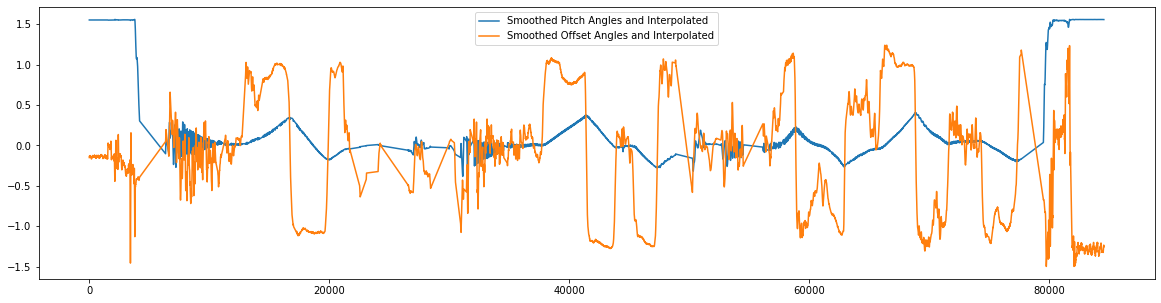

In [5]:
smoothed_pitch_angles = savgol_filter(pitch_angles, 101, 5)
x = smoothed_pitch_angles
xi = np.arange(len(x))
mask = np.isfinite(x)
xfiltered_pitch = np.interp(xi, xi[mask], x[mask])
plt.figure(figsize=(20,5))
plt.plot(list(range(len(xfiltered_pitch))), xfiltered_pitch, label="Smoothed Pitch Angles and Interpolated")

smoothed_offset_angles = savgol_filter(offset_angles, 101, 5)
x = smoothed_offset_angles
xi = np.arange(len(x))
mask = np.isfinite(x)
xfiltered_offset = np.interp(xi, xi[mask], x[mask])
plt.plot(list(range(len(xfiltered_offset))), xfiltered_offset, label="Smoothed Offset Angles and Interpolated")

plt.legend()

In [6]:
yaw_angles = np.array(yaw_angles)
threshold_array = yaw_angles > 0
zero_one = []

for i in range(len(threshold_array)-1):
    if threshold_array[i] == 0 and threshold_array[i+1] == 1:
        zero_one.append(i)

periods = [zero_one[i+1] - zero_one[i] for i in range(len(zero_one)-1)]
smoothed_periods = savgol_filter(periods, 101, 5)

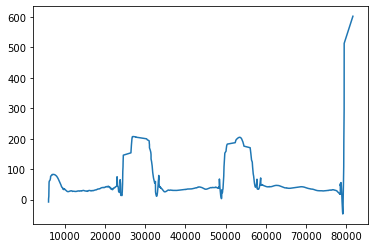

In [7]:
plt.plot(zero_one[:-1], smoothed_periods)

In [14]:
zero_one.index(12993)

181

In [18]:
zero_one.index(21509)

443

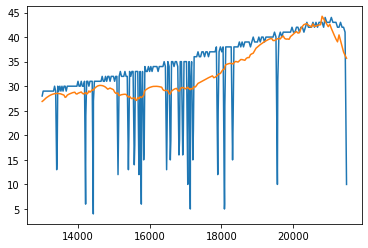

In [22]:
plt.plot(zero_one[181:443], periods[181:443])
plt.plot(zero_one[181:443], smoothed_periods[181:443])

In [23]:
np.average(600/smoothed_periods[181:443]) # average angular velocity

18.871309075071945

In [24]:
change_in_pitch = []
offset_angularspeed = []

for i in range(181,444):
    time_index = zero_one[i]
    next_time_index = zero_one[i+1]
    change_in_pitch.append((xfiltered_pitch[next_time_index] - xfiltered_pitch[time_index])/(next_time_index - time_index))
    offset_angularspeed.append(xfiltered_offset[time_index]/(600/smoothed_periods[i]))


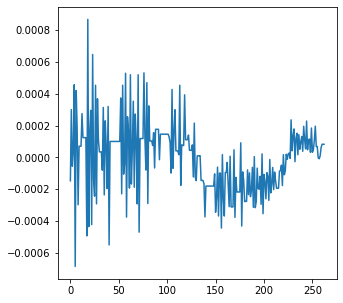

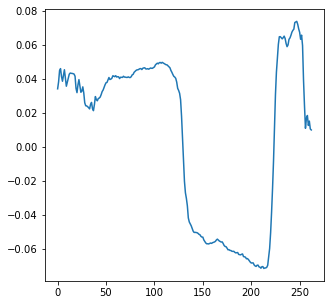

In [26]:
plt.figure(figsize=(5,5))
plt.plot(change_in_pitch)
plt.figure(figsize=(5,5))
plt.plot(offset_angularspeed)

In [27]:
ratio = np.array(change_in_pitch)/np.array(offset_angularspeed)

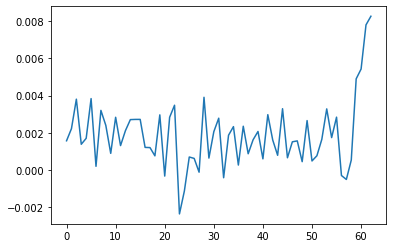

In [28]:
plt.plot(ratio[200:])

In [35]:
np.median(ratio[np.isfinite(ratio)])

0.0027075498443057825

In [40]:
smoothed_angular_speed_range = 600/smoothed_periods[181:443]

In [41]:
len(smoothed_angular_speed_range)

262

In [47]:
predicted_change_in_pitch = []
predicted_pitch = [xfiltered_pitch[12993]]

for i in range(12993, 21509):
    ratio_offset_speed = xfiltered_offset[i]/(smoothed_angular_speed_range[int((i-12993) / 8516 * 262)])
    change_in_pitch_value = ratio_offset_speed * 0.0027075498443057825
    predicted_change_in_pitch.append(change_in_pitch_value)
    predicted_pitch.append(predicted_pitch[-1] + change_in_pitch_value)

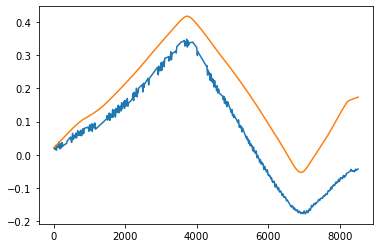

In [48]:
plt.plot(xfiltered_pitch[12993:21509])
plt.plot(predicted_pitch)